# Identification of organic compounds from their complex refractive index using deep learning

---


In [ ]:
# Install keras
# !pip install keras==2.1.6

In [ ]:
#load the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

#New imports
# %tensorflow_version 1.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# tf.keras.utils.to_categorical
%matplotlib inline

Importing our scrapped data, currently using github hosted file.
This data is a result of web scrapping "refractiveindex.info" website


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/riScrappedData.csv")
df.head()

,book,wl,n,k
0,CH4 (Methane),1.68,1.000436,NaN
1,CH4 (Methane),1.94,1.000436,NaN
2,CH4 (Methane),2.67,1.000433,NaN
3,CH4 (Methane),2.79,1.000431,NaN
4,CH4 (Methane),2.96,1.000428,NaN


Importing our uv_vis augmented data, currently using github hosted file.
This data is a result of data augmentation (Synthesizing refractive index data) using the sellmeier equation.

In [ ]:
uv_visAugmented = pd.read_csv("https://raw.githubusercontent.com/innokirigiti/mypublicfolder/main/uv_visAugmentedData5000books.csv")
uv_visAugmented.head()

,book,wl,n,k
0,22,0.4465,1.368170,0.000000e+00
1,22,0.3916,1.373850,2.109850e-07
2,6,0.6850,1.411420,0.000000e+00
3,36,0.4850,1.362881,0.000000e+00
4,18,0.5011,1.345787,0.000000e+00


Dealing with augmented data

In [ ]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
uv_visAugmented['wl_range'] = pd.cut(uv_visAugmented['wl'], [0,0.4,np.inf], labels= ['UV', 'Visible'])
uv_visAugmented.sample(3)

,book,wl,n,k,wl_range
189408,14,0.077842,1.660156,0.0,UV
32290,19,0.176408,1.000703,0.0,UV
237289,49,0.036651,1.559289,0.0,UV


In [ ]:
# Lets select rows within UV & Visible regions - Augmented
uvAugmented = uv_visAugmented.loc[uv_visAugmented['wl_range'].isin(['UV'])]
visAugmented = uv_visAugmented.loc[uv_visAugmented['wl_range'].isin(['Visible'])]

# Data visualization and pre-processing

## Handling missing values

In [ ]:
# Shape of the dataframe
df.shape

(248756, 4)

In [ ]:
# Counting null values from each column
df.isna().sum()

book       0
wl         0
n          0
k       9645
dtype: int64

There are 9645 missing values of K

## Grouping data by wavelengths
i.e 'UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'

In [ ]:
# Classifying the wavelengths to different categories,based on the range of Wavelengths
df['wl_range'] = pd.cut(df['wl'], [0,0.4,0.75,1.5,4.0, np.inf], labels= ['UV', 'Visible', 'Near_IR', 'IR', 'Far_IR'])
df.sample(3)

,book,wl,n,k,wl_range
62875,C3H7OH (Propanol),3.15505,1.39007,0.020790,IR
61527,C3H7OH (Propanol),2.61819,1.34717,0.000310,IR
148639,C6H5NO2 (Nitrobenzene),4.66616,1.50847,0.000089,Far_IR


Let’s see how many of each class is in our data set

In [ ]:
df['wl_range'].value_counts()

IR         129252
Far_IR      73576
Near_IR     37853
Visible      6268
UV           1807
Name: wl_range, dtype: int64

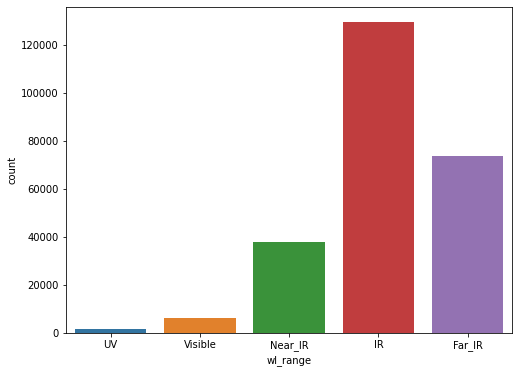

In [ ]:
# Visualising
sns.countplot(x ='wl_range', data = df)
plt.savefig('Fig1.jpeg', dpi = 400)

**Preview amount of augmented data**

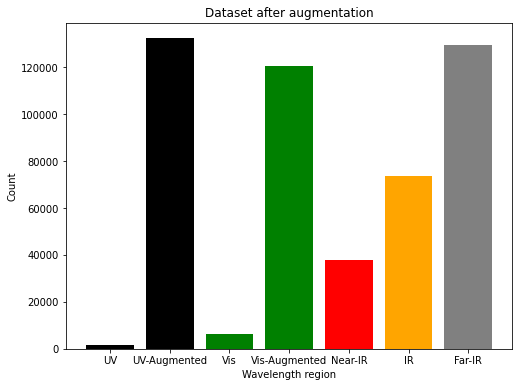

In [ ]:
fig, ax = plt.subplots()

wavelengths = ['UV','UV-Augmented', 'Vis', 'Vis-Augmented', 'Near-IR',
          'IR', 'Far-IR']
count = [1807, 132314, 6268, 120455, 37853, 73576, 129252 ]
bar_labels = ['UV','UV Augmented', 'Vis', 'Vis - Augmented',
              'Near-IR', 'IR', 'Far-IR']
bar_colors = ['black', 'black', 'green', 'green', 'red', 'orange', 'grey']

ax.bar(wavelengths, count, label=bar_labels, color = bar_colors)

ax.set_ylabel('Count')
ax.set_xlabel('Wavelength region')

ax.set_title('Dataset after augmentation')
plt.rcParams['figure.figsize'] = [6, 6]
plt.savefig('Fig4_augmented_DB.jpeg', dpi = 400)
plt.show()

**Defining Variable for different wavelengths**

In [ ]:
UV = df.loc[df['wl_range'].isin(['UV'])]
Visible = df.loc[df['wl_range'].isin(['Visible'])]
Near_IR = df.loc[df['wl_range'].isin(['Near_IR'])]
IR = df.loc[df['wl_range'].isin(['IR'])]
Far_IR = df.loc[df['wl_range'].isin(['Far_IR'])]

**Visualizing missing values of K**

In [ ]:
# Counting null values of K for each region
UV_missingK = UV['k'].isna().sum()
Vis_missingK = Visible['k'].isna().sum()
nearIR_missingK = Near_IR['k'].isna().sum()
IR_missingK = IR['k'].isna().sum()
farIR_missingK = Far_IR['k'].isna().sum()

In [ ]:
# Print the no of missing values of k
print('UV Null K values: ', UV_missingK)
print('Vis Null K values: ', Vis_missingK)
print('Near-IR Null K values: ', nearIR_missingK)
print('IR Null K values: ', IR_missingK)
print('Far-IR Null K values: ', farIR_missingK)

UV Null K values:  1066
Vis Null K values:  5182
Near-IR Null K values:  2794
IR Null K values:  419
Far-IR Null K values:  184


In [ ]:
# Determining the percent of missing values in each wavelength region
# Number of rows is given by len(dataframe)

# Print the percents of missing k values per wavelength region
print('Percents of missing extinction coefficients (k) per wavelength region \n ')

UV_missingKPercent = round((100 - (len(UV) - UV_missingK )/ len(UV) * 100), 2)
Vis_missingKPercent = round((100- (len(Visible) - Vis_missingK ) / len(Visible) * 100), 2)
nearIR_missingKPercent = round((100 -(len(Near_IR) - nearIR_missingK )/ len(Near_IR) * 100), 2)
IR_missingKPercent = round((100 -(len(IR) - IR_missingK ) / len(IR) * 100), 2)
farIR_missingKPercent = round((100 -(len(Far_IR) - farIR_missingK )/ len(Far_IR) * 100), 2)

print('Percent of k in UV: ', UV_missingKPercent)
print('Percent of k in Visible: ', Vis_missingKPercent)
print('Percent of k in Near-IR: ', nearIR_missingKPercent)
print('Percent of k in IR: ', IR_missingKPercent)
print('Percent of k in Far-IR: ', farIR_missingKPercent)

Percents of missing extinction coefficients (k) per wavelength region 
 
Percent of k in UV:  58.99
Percent of k in Visible:  82.67
Percent of k in Near-IR:  7.38
Percent of k in IR:  0.32
Percent of k in Far-IR:  0.25


In [ ]:
# Plot of % missing k values per region
# initialize data of regions.
data_missingKPercents = {'wl_range': ['UV', 'Visible', 'Near-IR', 'IR', 'Far-IR'],
        'missingKPercent': [UV_missingKPercent, Vis_missingKPercent, nearIR_missingKPercent, 
                IR_missingKPercent, farIR_missingKPercent]}

dfMissingKPercents = pd.DataFrame(data_missingKPercents)
dfMissingKPercents

,wl_range,missingKPercent
0,UV,58.99
1,Visible,82.67
2,Near-IR,7.38
3,IR,0.32
4,Far-IR,0.25


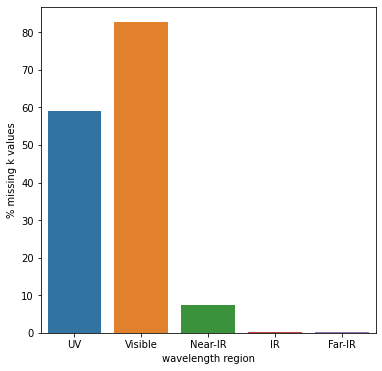

In [ ]:
# Visualising % missing k values per wavelength region
ax = sns.barplot(x ='wl_range', data = dfMissingKPercents, y = 'missingKPercent')
ax.set(ylabel='% missing k values', xlabel='wavelength region')
plt.rcParams['figure.figsize'] = [8, 6]
plt.savefig('Fig3-Percent_missing_k.jpeg', dpi = 400)

plt.show()

In [ ]:
# Determining the percent of missing values in UV & Visible Augmented data
# Number of rows is given by len(dataframe)

# Print the percents of missing k values per wavelength region
print('Percents of available extinction coefficients (k) per wavelength region - Augmented data\n ')

# Missing values for augmented data = missing values before augmentantion + added synthetic data

print('Percent of k in UV-Augmented: ', round((len(uvAugmented) - (UV_missingK + 130507) ) / len(uvAugmented) * 100, 2))
print('Percent of k in Visible-Augmented: ', round((len(visAugmented) - (Vis_missingK + 115187)) / len(visAugmented) * 100, 2))

Percents of available extinction coefficients (k) per wavelength region - Augmented data
 
Percent of k in UV-Augmented:  0.56
Percent of k in Visible-Augmented:  0.07


**Plotting Percent of missing k vs accuracies**

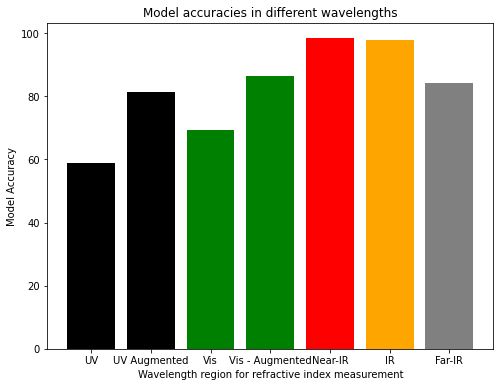

In [ ]:
fig, ax = plt.subplots()

wavelengths = ['UV','UV Augmented', 'Vis', 'Vis - Augmented', 'Near-IR',
          'IR', 'Far-IR']
model_accuracy = [59, 81.49, 69.22, 86.6, 98.44, 97.72, 84.09 ]
bar_labels = ['UV','UV Augmented', 'Vis', 'Vis - Augmented',
              'Near-IR', 'IR', 'Far-IR']
bar_colors = ['black', 'black', 'green', 'green', 'red', 'orange', 'grey']

ax.bar(wavelengths, model_accuracy, label=bar_labels, color = bar_colors)

ax.set_ylabel('Model Accuracy')
ax.set_xlabel('Wavelength region for refractive index measurement')

ax.set_title('Model accuracies in different wavelengths')
plt.rcParams['figure.figsize'] = [12, 16]
plt.savefig('Fig5-Testing_accuracies.jpeg', dpi = 400)

plt.show()

**Describing The data**

In [ ]:
# Describe new df with only Near-Infrared data
Far_IR.describe()

,wl,n,k
count,73576.000000,73576.000000,73392.000000
mean,8.955725,1.442561,0.017873
std,5.749281,0.096021,0.059402
min,4.000030,0.805570,0.000000
25%,5.123000,1.367920,0.000579
50%,7.071680,1.450935,0.002123
75%,11.079000,1.512940,0.011336
max,200.000000,2.206960,1.224330


In [ ]:
Far_IR.shape

(73576, 5)